In [1]:
from src.capsnet import CapsNet, ReconstructionNet, CapsNetWithReconstruction
from src.dataset_generator import DatasetGenerator
from src.datasets import GraphemesDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import os

%matplotlib inline
%load_ext autoreload
%autoreload 2

use_gpu = True
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")


# Generate Semitic Regular centered letters

In [2]:
selected_scripts = ["Hieroglyph", "Proto-Sinaitic", "Phoenician", "Ancient North-Arabian",
                        "Ancient South-Arabian", "Ge'ez", "Paleo-Hebrew", "Samaritan", "Aramaic", "Syriac",
                        "Hebrew", "Nabataean", "Arabic"]
font_encoding_file = "data/encoding/dotless_encoding.csv"
fonts_dir = "data/fonts/"

dummy = True

ds_dir_format = "datasets/{0}_dataset/"
# dataset categories
base_ds_dir = ds_dir_format.format("base")


In [3]:
dataset_generator = DatasetGenerator(font_encoding_file, base_ds_dir, fonts_dir,
                                     selected_scripts=selected_scripts,
                                     translate=False,
                                     rotation_dist=(0,0),
                                     sizes=[22],
                                     max_augmentations=1, dummy=dummy)

dataset_generator.generate_dataset()
imgs = dataset_generator.get_image_paths()

alphabet_dataset = GraphemesDataset(base_ds_dir, test_size=0)
letter_to_label = {alphabet_dataset.classes[i]: i for i in range(len(alphabet_dataset.classes))}

/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/dataset_generator.py:162: PerformanceWarning: indexing past lexsort depth may impact performance.
  self.img_paths.loc[(font_name, letter, script), "img_path"] = img_full_path
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/dataset_generator.py:162: PerformanceWarning: indexing past lexsort depth may impact performance.
  self.img_paths.loc[(font_name, letter, script), "img_path"] = img_full_path


total number of images generated: 9610
Number of images generated for each letter: {'aleph': 381, 'bet': 386, 'gimmel': 390, 'dalet': 391, 'he': 403, 'waw': 384, 'zayin': 382, 'het': 392, 'tet': 382, 'yod': 370, 'kaph': 624, 'lamed': 393, 'mem': 583, 'nun': 597, 'samekh': 391, 'ayin': 405, 'pe': 588, 'tsadi': 599, 'qoph': 380, 'resh': 384, 'shin': 426, 'taw': 379}


In [4]:
import skia

def get_image(image_path):
    try:
        return skia.Image.open(image_path).toarray()[..., :1]
    except:
        return None

# apply get_image to all images in dataset_generator.img_paths to get a new dataframe of images
imgs["img"] = imgs["img_path"].apply(get_image)
imgs = imgs.dropna()



/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_17512/1018258909.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imgs["img"] = imgs["img_path"].apply(get_image)


In [5]:
import torch
from torchvision import transforms

def get_tensor(image):
    if image is None:
        return None
    return transforms.ToTensor()(image)

imgs["img_tensor"] = imgs["img"].apply(get_tensor)

In [6]:
labels = imgs.index.get_level_values(1).to_series().apply(lambda x: letter_to_label[x])
imgs["y"] = labels.values


# imshow a sample from the dataset

# Load CapsNet model

In [7]:
routing_iterations = 3

letter_labeled_capsnets = {}
n_letters = 22
model_path = "results/experiment 3/capsnet/letter_labels/020_capsnet_rich_rotation_alphabet.pth"


# Load trained model
model = CapsNet(routing_iterations, n_letters)
reconstruction_model = ReconstructionNet(16, n_letters)
model = CapsNetWithReconstruction(model, reconstruction_model)
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
model.eval()

CapsNetWithReconstruction(
  (capsnet): CapsNet(
    (conv1): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    (primaryCaps): PrimaryCapsLayer(
      (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
    )
    (digitCaps): CapsLayer(
      (routing_module): AgreementRouting()
    )
  )
  (reconstruction_net): ReconstructionNet(
    (fc1): Linear(in_features=352, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=784, bias=True)
  )
)

# Encode to latent representetions

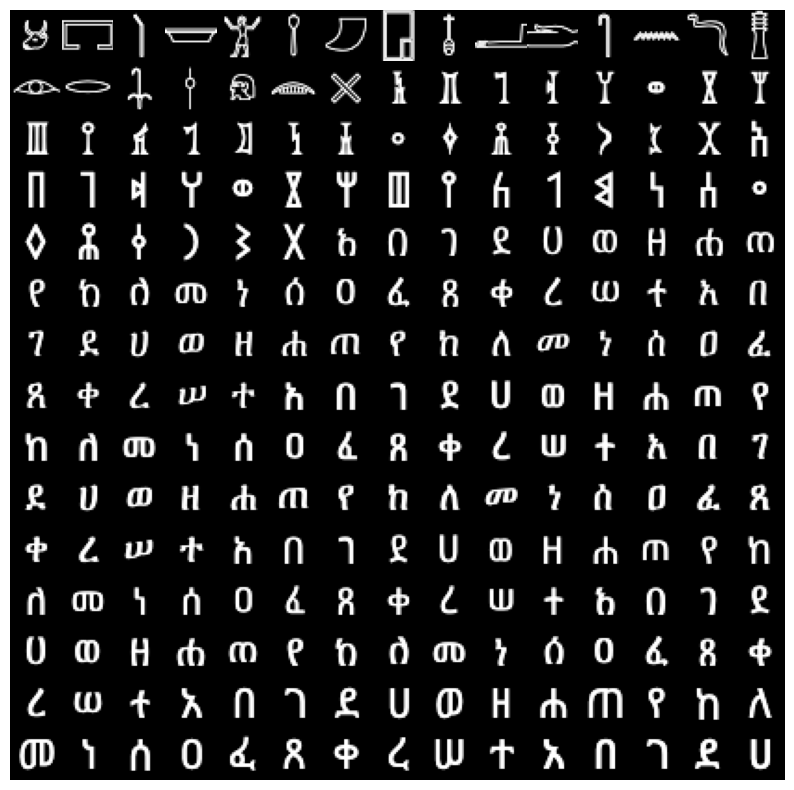

In [8]:
#letter = "tet"
# filter the dataset to only include images of a single letter
#df = imgs[imgs.index.get_level_values(1) == letter]
df = imgs

# imshow a grid of images from the dataset and set background to black
fig, axes = plt.subplots(15, 15, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(df["img"].iloc[i], cmap='gray')
    ax.set_axis_off()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [9]:
from tqdm import tqdm
from torch.autograd import Variable

tensors = df["img_tensor"].values.tolist()

# go over all tensors in batches of 256 and get their latent representations
# using model.capsnet
latent_representations = []
for i in tqdm(range(0, len(tensors))):
    batch = Variable(tensors[i].unsqueeze(0), volatile=True)
    batch = batch.to(device)
    latent, probs = model.capsnet(batch)
    latent_representations.append(latent)

df["latent"] = torch.cat(latent_representations).detach().numpy().tolist()

  0%|          | 0/7961 [00:00<?, ?it/s]/var/folders/tz/nj1np8hj5sn9b_q8m1628ssr0000gn/T/ipykernel_17512/1181310580.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  batch = Variable(tensors[i].unsqueeze(0), volatile=True)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(self.b)
/Users/bensa/MLDS/Deep Learning/Final Project/Deep Graphemics/src/capsnet.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
100%|██████████| 7961/7961 [02:50<00:00, 46.69it/s]


# Generate reconstructions

In [10]:
def get_reconstruction(tensor, y, model=model):
    return model.reconstruction_net(tensor, y).data.view(28, 28).numpy()

tensors = torch.cat(latent_representations)
reconstructions = []
y = torch.LongTensor(df["y"].values.tolist()).to(device)
for i in tqdm(range(0, len(tensors))):
    batch = tensors[i].unsqueeze(0)
    batch = batch.to(device)
    reconstruction = model.reconstruction_net(batch, y[i])
    reconstruction = reconstruction.data.cpu().numpy()[0].reshape(28, 28)
    reconstructions.append(reconstruction)

df["reconstruction"] = reconstructions

100%|██████████| 7961/7961 [00:04<00:00, 1862.89it/s]


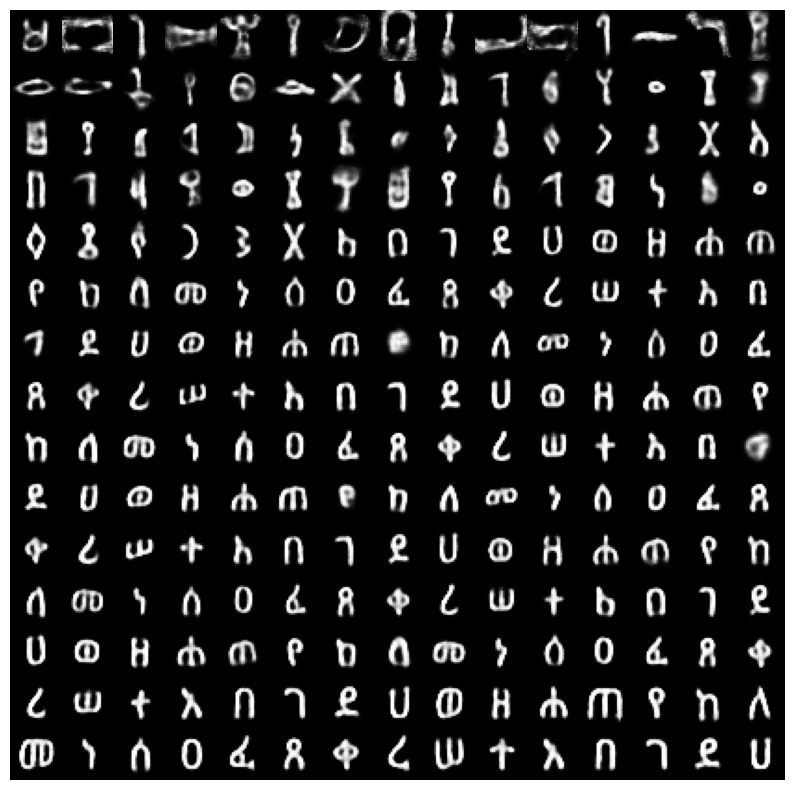

In [15]:
# show reconstructions
fig, axes = plt.subplots(15, 15, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(df["reconstruction"][i].squeeze(), cmap='gray')
    ax.set_axis_off()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

# Interpolate between two points in latent space

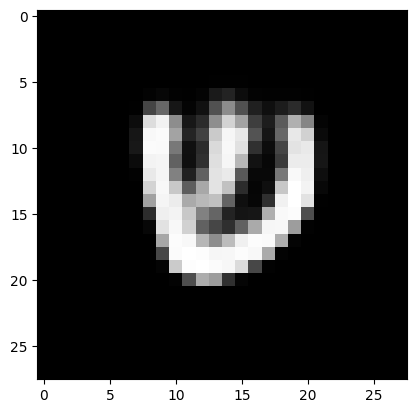

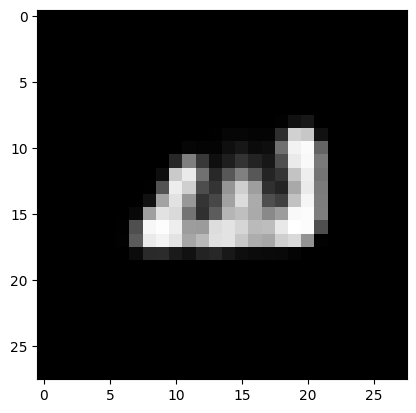

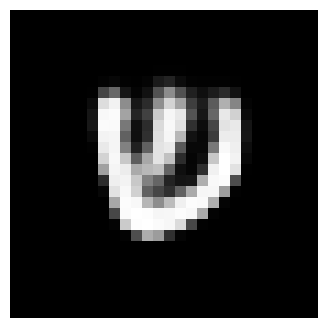

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def caps_interpolation(t, model, latent1, latent2, y):
    latent_inter = latent1 * (1 - t) + latent2 * t
    inter_image = model.reconstruction_net(latent_inter, y).data.view(28, 28).numpy()
    return inter_image

def generate_animation(letter, latent1, latent2, y):

    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_axis_off()

    num_frames = 30

    def update(frame):
        if frame < num_frames / 2:
            t = frame / (num_frames / 2)
            t = np.sin(t * np.pi / 2)
        else:
            t = (frame - num_frames / 2) / (num_frames / 2)
            t = 1 - np.sin(t * np.pi / 2)

        inter_image = caps_interpolation(t, model, latent1, latent2, y)
        ax.imshow(inter_image, cmap='gray')
        return ax

    ani = FuncAnimation(fig, update, frames=num_frames, interval=100)
    return ani

def series_to_tensor(series):
    return torch.Tensor(np.array(series.tolist())).squeeze().unsqueeze(1)

letter = "shin"

tensors = series_to_tensor(df["latent"])
heb_tensors = torch.Tensor(np.array(df[(df.index.get_level_values(2) == "Hebrew") & (df.index.get_level_values(1) == letter)]["latent"].tolist()))
ar_tensors = torch.Tensor(np.array(df[(df.index.get_level_values(2) == "Arabic") & (df.index.get_level_values(1) == letter)]["latent"].tolist()))

y = torch.Tensor([letter_to_label[letter]]).long()

latent1 = heb_tensors[1].unsqueeze(0)
latent2 = ar_tensors[1].unsqueeze(0)
y = y[0]

plt.imshow(get_reconstruction(latent1, y), cmap='gray')
plt.show()
plt.imshow(get_reconstruction(latent2, y), cmap='gray')
plt.show()


ani = generate_animation(letter, latent1, latent2, y)
display(HTML(ani.to_jshtml()))

In [14]:
# save animation
ani.save("animations/{}_animation.gif".format(letter), writer="imagemagick", fps=10)

# Higher order interpolation